### Problem Statement

Customer reviews on Amazon fine food services were very long and boring. Analyzing these reviews manually is time consuming and tendious task. To save our time and efforts, we use the RNN model to summarize those reviews. 

We used the dataset from here(https://www.kaggle.com/snap/amazon-fine-food-reviews)

#### Import the Libraries

In [2]:
from attention import AttentionLayer
import numpy as np
import pandas as pd 
import re
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12014\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Read the dataset

This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text review, and summary.

We’ll take a sample of 100,000 reviews to reduce the training time of our model. 

In [3]:
data=pd.read_csv("C:/Users/12014/Documents/Python Scripts/PYTHON/Neural Nets/project/amazon-fine-food-reviews/Reviews.csv",nrows=100000)

#### Drop Duplicates and NA values

In [4]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

#### Sample Data

In [5]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


#### Preprocessing

in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

Here is the dictionary that we will use for expanding the contractions:

In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

#### Data Cleaning

1.Convert everything to lowercase

2.Contraction mapping

3.Remove (‘s)

4.Remove any text inside the parenthesis ( )

5.Eliminate punctuations and special characters

6.Remove stopwords

7.Remove short words

In computing, stop words are words which are filtered out before or after processing of natural language data (text). Stop words are generally the most common words in a language.


In [9]:
stop_words = set(stopwords.words('english'))  
# 'a',
#  'about',
#  'above',
#  'after',
#  'again',
#  'against',
#  'ain',
#  'all',
#  'am',

In [10]:
def text_cleaner(text,num):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) 
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()
    print(newString)


In [11]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

#### Sample cleaned Text

In [12]:
cleaned_text[:5]  

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [13]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

#### Sample summary Text

In [14]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [15]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

####  Distribution of the sequences

Here, we are analyzing the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

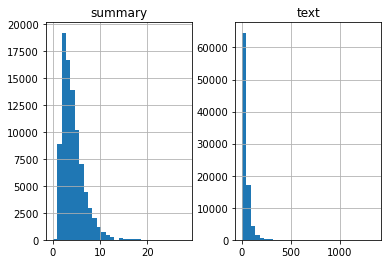

In [16]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [17]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=10):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9788737969486887


We observe that 97.8% of the summaries have length below 10. So, we can fix maximum length of summary to 10.

Let us fix the maximum length of review to 50

In [18]:
max_text_len=50
max_summary_len=10

Selecting the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [19]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

Adding the **START** and **END** special tokens at the beginning and end of the summary. Here, we have chosen **sostok** and **eostok** as START and END tokens.

In [20]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [21]:
ind=[]
for i in range(len(df['summary'])):
    cnt=0
    for j in df['summary'][i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

df['summary'] = np.delete(df['summary'],ind, axis=0)
df['text']=np.delete(df['text'],ind, axis=0)

#### Splitting dataset into training and validation set(9:1)

In [22]:
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [23]:
x_tr.shape

(59961,)

#### Text tokenizer to convert sequence of word into sequence of numbers

In [24]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [25]:
#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

In [26]:
#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_text_len, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_text_len, padding='post')

x_voc   =  len(x_tokenizer.word_index) +1

In [27]:
x_voc

32392

####  Summary Tokenizer

In [28]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer() 
y_tokenizer.fit_on_texts(list(y_tr))

In [29]:
#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

In [30]:
#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   len(y_tokenizer.word_index) +1

In [31]:
y_voc

11324

# Model building


**Return Sequences = True**: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

**Return State = True**: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

**Initial State**: This is used to initialize the internal states of the LSTM for the first timestep

**Stacked LSTM**: Stacked LSTM has multiple layers of LSTM stacked on top of each other. 
This leads to a better representation of the sequence.

Here, we are building a 2 stacked LSTM for the encoder:

In [32]:
from tensorflow.keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=15

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# #encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output1)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 15)       485880      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 300), (N 379200      embedding[0][0]                  
______________________________________________________________________________________________

In [33]:
encoder_output1.shape

TensorShape([None, 50, 300])

we are using the sparse categorical cross-entropy as the loss function.

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Early stopping is used to stop training the neural network at the right time by monitoring a user-specified metric. Here, we are monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases:


In [35]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 10% of our dataset):

In [36]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 59961 samples, validate on 6663 samples
Epoch 1/50
59961/59961 [==============================] - 2369s 40ms/sample - loss: 2.8769 - val_loss: 2.5089
Epoch 2/50
59961/59961 [==============================] - 2135s 36ms/sample - loss: 2.5710 - val_loss: 2.4164
Epoch 3/50
59961/59961 [==============================] - 2162s 36ms/sample - loss: 2.5021 - val_loss: 2.3717
Epoch 4/50
59961/59961 [==============================] - 3683s 61ms/sample - loss: 2.4565 - val_loss: 2.3329
Epoch 5/50
59961/59961 [==============================] - 3569s 60ms/sample - loss: 2.4167 - val_loss: 2.2976
Epoch 6/50
59961/59961 [==============================] - 34846s 581ms/sample - loss: 2.3843 - val_loss: 2.2768
Epoch 7/50
59961/59961 [==============================] - 1791s 30ms/sample - loss: 2.3569 - val_loss: 2.2597
Epoch 8/50
59961/59961 [==============================] - 2162s 36ms/sample - loss: 2.3328 - val_loss: 2.2469
Epoch 9/50
59961/59961 [==============================] - 3249s 54ms/

####  Diagnostic plot

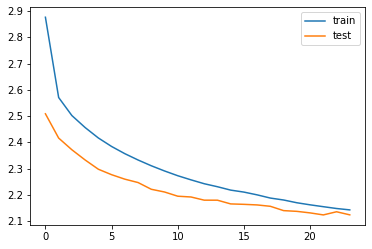

In [37]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [38]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Inference

Set up the inference for the encoder and decoder:

In [39]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

We are defining a function below which is the implementation of the inference process.

In [40]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

converting an integer sequence to a word sequence for summary as well as the reviews:

In [41]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Here are a few summaries generated by the model:

In [42]:
for i in range(1000,1200):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: loved mold wished could used one occasion last use make suckers daughter first birthday going way mold could salvaged would liked kept use occasions price matter much served main purpose 
Original summary: could use only once 
Predicted summary:  great product


Review: cat started throwing business trip used amazon prime overnight friend taking care switched food stopped vomiting br br happy food months long time able get anytime anywhere big plus br br also nice round shaped food works well automatic cat feeders 
Original summary: great food 
Predicted summary:  my cats love this food


Review: glad see product line hard find store makes wonderful chocolate sauce ice cream best ever 
Original summary: droste cocoa 
Predicted summary:  great product


Review: treats wife cats eats give anything else dogs end eating funny like much learned beg cannot lose treats cat love 
Original summary: cat love these things 
Predicted summary:  my dog loves these


Review: crystal light fla

Predicted summary:  great tasting sauce


Review: love cheerios really wonderful value continue getting cereal regular home breakfasts 
Original summary: apple cheerios 
Predicted summary:  great product


Review: got kids easter basket something different loved tastes great even travels well great treat take car stick purse time craving ice cream cannot 
Original summary: tastes great 
Predicted summary:  great for breakfast


Review: meals disgusting made baby food first kid time second kid ordered bunch earth best food wish would ordered one pack start glob terrible consistency barely edible flavor baby eats heat bit accounting baby taste 
Original summary: gross food 
Predicted summary:  my cats love this food


Review: thankful found pouches four year old ok eater comes fruit veggies sucks like juice pouches asks another love getting great antioxidants fiber omega especially since fish eater eat time go tastes really good cold hot day 
Original summary: my four year old loves thes

Predicted summary:  not good


Review: papillions love greenies help keep tartar control breed notorious bad tartar build teeth dentals twice year using greenies daily dental year saves us year 
Original summary: papillions love greenies 
Predicted summary:  my dogs love these


Review: cutest make traveler would given stars smaller expected lot makeup would suggest product like want necessities going small trip perfect color fantastic shiny bright 
Original summary: good product 
Predicted summary:  great product


Review: bought two kinds davidson bulk teas darjeeling gunpowder green disappointed quality make kind murky harsh tea darjeeling light color aftertaste like pekoe gunpowder green weak flat certainly would recommend 
Original summary: very low quality 
Predicted summary:  not as good as expected


Review: admit like french vanilla coffee heavy vanilla side much stronger coffee brew meaning sugar creamer needed tone coffee flavor hand reasonable alternative preferred brand sa

Predicted summary:  dogs love them


Review: bought based rave reviews posted previously one main ingredients msg gotta way make good bbq rub loaded stuff gives wife nasty headaches 
Original summary: loaded with msg 
Predicted summary:  not good


Review: came handy breakfast snack well lunch snack little sweet 
Original summary: nice snack but sweet 
Predicted summary:  great snack


Review: buy month old son loves however extremely messy everything turns red prepared 
Original summary: good but verrry messy 
Predicted summary:  great product


Review: pleased product great tasting coffee quick breakfast trying banana walnut discovered chocolate chip version ordered definitely chocolate chip favorite 
Original summary: pleased to learn how tasty they are 
Predicted summary:  great coffee


Review: eating larabar bars years love pecan pie bars days ago received box warehouse kentucky box oil spots opened bar strange odor almost like fermentation ate lunch work bars eat think temperatu

Predicted summary:  great product


Review: luved original zico taste totally different br introduced pure coconut water pasteurized says concentrate br br taste little different 
Original summary: product changed 
Predicted summary:  not bad


Review: drink want price afford br br alarmed meticulously packaged came br br pleasantly surprised happy drinking orangina wherever br br maybe maybe may get sexxy cougar man 
Original summary: sexxy cougar man 
Predicted summary:  great product


Review: discovered hot sauce traveling around belize tables lot restaurants lovely tang grapefruit tongue burning hot pleasing gentle heat never without 
Original summary: one of my favorites 
Predicted summary:  best chocolate ever


Review: pop chips great heard really good totally agree love able flavors like variety br chips delivered quickly safely 
Original summary: love those chips 
Predicted summary:  great chips


Review: works great rottie could fit thru pls mk bigger one br br jd 
Original 

Predicted summary:  great tasting


Review: got gift tastes like sold junior highers make money chocolate much cheap waxy choco flavored covering ball sugar lard buy disgusting product tricked 
Original summary: chocolate you can buy and it tastes like it 
Predicted summary:  not as advertised


Review: dog well food recent price increase means shopping elsewhere product mention almost always least one bag order come unsealed shipment due poor packaging enough reasons shop elsewhere 
Original summary: great food but no longer good value on amazon 
Predicted summary:  my dog loves these


Review: poor quality price flavor crabmeat way processed surprised easily crabmeat lumps practically disintegrated flakes preparing crabcakes learned lesson pay bit grocery store quality jumbo lump crab meat 
Original summary: really bad crabmeat for the price 
Predicted summary:  not as advertised


Review: simply like taste ginger bitter even adding sugar tried making tea weaker several times simply 